# Анализ развлекательного приложения Procrastinate Pro+.

Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки.

**Цель анализа**: разобраться в причинах и помочь компании выйти в плюс.

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

**Описание данных**

Файл `visits_info_short.csv` хранит лог сервера с информацией о посещениях сайта, `orders_info_short.csv` — информацию о заказах, а `costs_info_short.csv` — информацию о расходах на рекламу.

Структура `visits_info_short.csv`:
- `User Id` — уникальный идентификатор пользователя,
- `Region` — страна пользователя,
- `Device` — тип устройства пользователя,
- `Channel` — идентификатор источника перехода,
- `Session Start` — дата и время начала сессии,
- `Session End` — дата и время окончания сессии.

Структура `orders_info_short.csv`:
- `User Id` — уникальный идентификатор пользователя,
- `Event Dt` — дата и время покупки,
- `Revenue` — сумма заказа.

Структура `costs_info_short.csv`:
- `dt` — дата проведения рекламной кампании,
- `Channel` — идентификатор рекламного источника,
- `costs` — расходы на эту кампанию.

Предстоит изучить:
- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

**План работы**

[***Шаг 1. Загрузка и предобработка данных***](#1)

[***Шаг 2. Задача функций***](#2)

[***Шаг 3. Исследовательский анализ данных***](#3)

[***Шаг 4. Маркетинг***](#4)

[***Шаг 5. Оценка окупаемости***](#5)

[***Шаг 6. Общий вывод***](#6)

<a id ='1'></a>
### Загрузка данных и предобработа

Загрузим данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visits_info_short.csv);
- заказы: `/datasets/orders_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders_info_short.csv);
- расходы: `/datasets/costs_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/costs_info_short.csv).

Изучим данные и выполним предобработку.

In [1]:
import pandas as pd
from datetime import date, datetime, timedelta
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    visits = pd.read_csv('visits_info_short.csv')
    orders = pd.read_csv('orders_info_short.csv')
    costs = pd.read_csv('costs_info_short.csv')
except:
    visits = pd.read_csv('/datasets/visits_info_short.csv')
    orders = pd.read_csv('/datasets/orders_info_short.csv')
    costs = pd.read_csv('/datasets/costs_info_short.csv')

In [3]:
# функция для обзора датафрейма
def df_info(df, n=5):
    display(df.head(n))
    print('*' * 50)
    df.info()
    print('*' * 50)
    print(f'Количество пропусков в датафрейме: {df.duplicated().sum()}')

In [4]:
df_info(visits, 10)

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40
5,90242400005,United States,iPhone,RocketSuperAds,2019-05-01 07:14:52,2019-05-01 08:19:56
6,43958116050,United States,Android,organic,2019-05-01 09:03:21,2019-05-01 10:08:39
7,185365244969,United States,iPhone,organic,2019-05-01 09:37:03,2019-05-01 10:00:43
8,446013509831,United States,iPhone,RocketSuperAds,2019-05-01 10:26:00,2019-05-01 10:59:17
9,100970711362,United States,Mac,TipTop,2019-05-01 04:39:53,2019-05-01 04:57:05


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
**************************************************
Количество пропусков в датафрейме: 0


Из обзора датафрейма с информацией о посещениях сайта можно отметить:
- присутствует 5 столбцов и 309901 строка;
- пропуски отсутствуют;
- явные дубликаты отсутствуют;
- названия столбцов стоит привести к snake_case;
- столбцы `Session Start` и `Session End` содержат информацию о времени, стоит скорректировать тип данных этих столбцов
- стоит проверить на наличие неявных дубликатов столбцы `Region`, `Device`, `Channel`

In [5]:
# приводим названия столбцов к snake_case
visits.columns = [x.lower().replace(' ', '_') for x in visits.columns]

In [6]:
# преобразование данных о времени
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [7]:
# проверка на неявные дубликаты
display(visits['region'].unique())
display(visits['device'].unique())
visits['channel'].unique()

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object)

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

Неявные дубликаты отсутствуют, название столбцов и тип данных изменены. Датафрейм с информацией о посещениях сайта готов к анализу.

In [8]:
df_info(visits)

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB
**************************************************
Количество пропусков в датафрейме: 0


In [9]:
df_info(orders, 10)

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99
5,129100331057,2019-05-01 01:56:28,4.99
6,626807144131,2019-05-01 02:39:21,4.99
7,914062168985,2019-05-01 02:02:18,4.99
8,769669137453,2019-05-01 03:39:47,4.99
9,434198630691,2019-05-01 18:16:50,5.99


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
**************************************************
Количество пропусков в датафрейме: 0


Из обзора датафрейма с информацией о заказах можно отметить:
- содержит 3 столбца и 40212 строк;
- пропуски отсутствуют;
- название столбцов стоит привести к snake_case;
- столбец `Event Dt` содержит информацию о дате и времени, стоит поменять тип данных столбца.

In [10]:
# приводим название столбцов к snake_case
orders.columns = ['user_id', 'event_dt', 'revenue']

In [11]:
# изменение типа данных
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

Название столбцов и тип данных изменены. Датафрейм с информацией о заказах готов к анализу.

In [12]:
df_info(orders)

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB
**************************************************
Количество пропусков в датафрейме: 0


In [13]:
df_info(costs, 10)

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1
5,2019-05-06,FaceBoom,118.8
6,2019-05-07,FaceBoom,101.2
7,2019-05-08,FaceBoom,100.1
8,2019-05-09,FaceBoom,93.5
9,2019-05-10,FaceBoom,104.5


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
**************************************************
Количество пропусков в датафрейме: 0


Из обзора датафрейма с информацией о расходах на рекламу можно отметить:
- присутствует 3 столбца и 1800 строк;
- пропуски отсутствуют;
- явные дубликаты отсутствуют;
- названия столбцов стоит привести к snake_case;
- столбец `dt` содержит информацию о времени, стоит скорректировать тип данных;
- стоит проверить на наличие неявных дубликатов столбец `Channel`

In [14]:
# приводим название столбцов к snake_case
costs.columns = ['dt', 'channel', 'costs']

In [15]:
# изменение типа данных
costs['dt'] = pd.to_datetime(costs['dt'])

In [16]:
costs['channel'].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

Неявные дубликаты отсутствуют, названия столбцов и тип данных изменены. Датафрейм с информацией о расходах на рекламу готов к анализу.

In [17]:
df_info(costs)

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       1800 non-null   datetime64[ns]
 1   channel  1800 non-null   object        
 2   costs    1800 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 42.3+ KB
**************************************************
Количество пропусков в датафрейме: 0


**Вывод**
- Пропуски в датафреймах отсутствуют;
- дубликаты отсутствуют;
- тип данных приведен к нужному там, где это требовалось;
- все названия столбцов приведены к snake_case.

<a id ='2'></a>
### Задайте функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

Определяем функции для вычисления значений метрик:

In [18]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['dt'] = pd.to_datetime(profiles['dt'], format="%Y-%m-%d")
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [19]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [20]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [21]:
def get_ltv(
    profiles,  # Шаг 1. Получить профили и данные о покупках
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # Шаг 2. Добавить данные о покупках в профили

    result_raw = result_raw.merge(
        # добавляем в профили время совершения покупок и выручку
        purchases[['user_id', 'event_dt', 'revenue']],
        on='user_id',
        how='left',
    )

    # Шаг 3. Рассчитать лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):

        # Шаг 3. Построить таблицу выручки
        # строим «треугольную» таблицу
        result = df.pivot_table(
            index=dims,
            columns='lifetime',
            values='revenue',  # в ячейках — выручка за каждый лайфтайм
            aggfunc='sum',
        )

        # Шаг 4. Посчитать сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)

        # Шаг 5. Вычислить размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )

        # Шаг 6. Объединить размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)

        # Шаг 7. Посчитать LTV
        # делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        # сохраняем в датафрейм данные пользователей и значения CAC, 
        # добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

Определяем функции для построения графиков:

In [22]:
# функция для сглаживания датафрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [23]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [24]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [25]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

<a id ='3'></a>
### Исследовательский анализ данных

- Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.
- Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [26]:
# составим профили пользователей
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [27]:
# найдем минимальную и максимальную даты привлечения
display(profiles['dt'].min(), profiles['dt'].max())

Timestamp('2019-05-01 00:00:00')

Timestamp('2019-10-27 00:00:00')

**1 мая 2019 года** - минимальная дата привлечения пользователей

**27 октября 2019 года** - максимальная дата привлечени пользователей, момент анализа

Эти даты соответствуют периоду, указанному в задании.

Выясним, из каких **стран** пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. 

In [28]:
# зададим функцию для создания таблиц с долей платящих пользователей по категориям
def payers_share(category):
    # находим количество пользователей в каждой категории и долю платящих
    category_payers = profiles.groupby(category).agg({'user_id':'count',
                                                      'payer':('sum', 'mean')}
                                                    )
    category_payers['users_share'] = round(category_payers['user_id'] / len(profiles), 3)
    # переименовываем столбцы
    category_payers.columns = ['users_count',
                               'payers_count',
                               'payers_perc',
                               'users_share']
    # сортируем
    display(category_payers.sort_values(by='payers_perc', ascending=False)
     .style.format({'payers_perc': '{:.2%}', 'users_share': '{:.1%}'}))

In [29]:
# доля платящих пользователей по регионам
payers_share('region')

,users_count,payers_count,payers_perc,users_share
region,,,,
United States,100002,6902,6.90%,66.7%
Germany,14981,616,4.11%,10.0%
UK,17575,700,3.98%,11.7%
France,17450,663,3.80%,11.6%


Больше всего в приложение приходят пользователи из США (66.7%), самая большая доля платящих так же у пользователей из США (6.9%). Стоит отметить, что хотя общее количество привлеченных пользователей из Германии меньше, чем из Великобритании или Франции, доля платящих пользователей в Германии больше.

Проанализируем, какими **устройствами** пользуются клиенты и какие устройства предпочитают платящие пользователи.

In [30]:
# доля платящих пользователей по устройствам
payers_share('device')

,users_count,payers_count,payers_perc,users_share
device,,,,
Mac,30042,1912,6.36%,20.0%
iPhone,54479,3382,6.21%,36.3%
Android,35032,2050,5.85%,23.4%
PC,30455,1537,5.05%,20.3%


Больше всего клиентов пользуются устройствами iPhone. Клиентов с устройствами Mac меньше всего, однако платящие пользователи предпочитают устройства Mac. Возможно в дальнейшем стоит сделать на этом акцент и привлечь больше поьзователей с устройствами Mac.

Меньше всего платящих пользователей приходится на PC.

Проанализируем **рекламные источники привлечения** и определим каналы, из которых пришло больше всего платящих пользователей

In [31]:
# доля платящих пользователей по источнику привлечения
payers_share('channel')

,users_count,payers_count,payers_perc,users_share
channel,,,,
FaceBoom,29144,3557,12.20%,19.4%
AdNonSense,3880,440,11.34%,2.6%
lambdaMediaAds,2149,225,10.47%,1.4%
TipTop,19561,1878,9.60%,13.0%
RocketSuperAds,4448,352,7.91%,3.0%
WahooNetBanner,8553,453,5.30%,5.7%
YRabbit,4312,165,3.83%,2.9%
MediaTornado,4364,156,3.57%,2.9%
LeapBob,8553,262,3.06%,5.7%


Больше всего органических пользователей, однако доля платящих органических пользователей самая маленькая, что вполне логично. Больше всего платящих пользователей пришло из каналов `FaceBoom`, `TipTop`, `AdNonSense`, `lambdaMediaAds`.

<a id ='4'></a>
### Маркетинг

- Посчитаем общую сумму расходов на маркетинг.
- Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Построим график с визуализацией динамики изменения расходов во времени по неделям по каждому источнику. Затем на другом графике визуализируем динамику изменения расходов во времени по месяцам по каждому источнику.
- Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.

**Расчет общей суммы расходов и анализ трат в зависимости от источника привлечения пользователей**

Посчитаем общую сумму расходов на маркетинг

In [32]:
costs.head()

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [33]:
# общая сумма маркетинговых затрат
round(costs['costs'].sum(), 1)

105497.3

Общая сумма затрат на маркетинг по всем каналам привлечения составляет 105497,3 д.е.

Проанализируем затраты на маркетинг в разбивке по рекламным источникам.

In [34]:
# затраты по каждому источнику в ден. выражении
channels_costs = costs.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs', ascending=False)
# доля затрат по каждому источнику в общей сумме затрат
channels_costs['costs, %'] = round(channels_costs['costs'] / costs['costs'].sum() * 100, 1)
channels_costs

,costs,"costs, %"
channel,,
TipTop,54751.30,51.9
FaceBoom,32445.60,30.8
WahooNetBanner,5151.00,4.9
AdNonSense,3911.25,3.7
OppleCreativeMedia,2151.25,2.0
RocketSuperAds,1833.00,1.7
LeapBob,1797.60,1.7
lambdaMediaAds,1557.60,1.5
MediaTornado,954.48,0.9


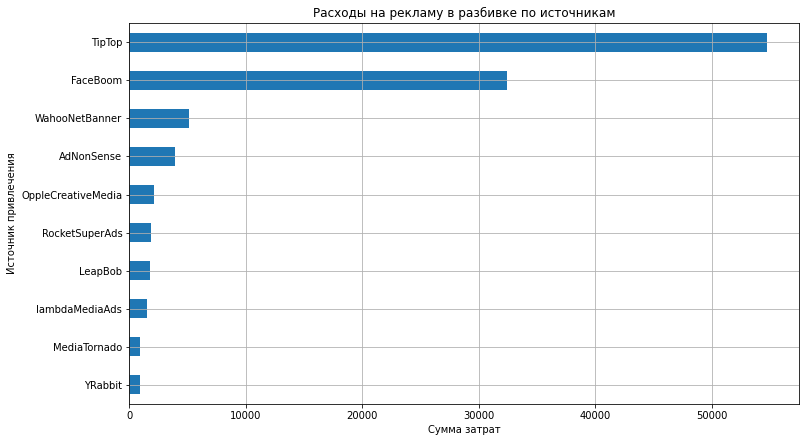

In [35]:
channels_costs['costs'].sort_values(ascending=True).plot(kind='barh',
                                                         figsize=(12, 7),
                                                         grid=True,
                                                         title='Расходы на рекламу в разбивке по источникам')
plt.xlabel('Сумма затрат')
plt.ylabel('Источник привлечения')
plt.show()

*Вывод:*

- Больше всего потрачено денег на источники `TipTop` и `FaceBoom`
- На источники `TipTop` и `FaceBoom` затрачено более 80% всего бюджета на рекламу
- Меньше всего денег потрачено на источник `YRabbit`.

**Анализ динамики расходов во времени**

In [36]:
# столбец с номером месяца
costs['month'] = costs['dt'].dt.month
# столбец с номером недели
costs['week'] = costs['dt'].dt.week
costs

,dt,channel,costs,month,week
0,2019-05-01,FaceBoom,113.3,5,18
1,2019-05-02,FaceBoom,78.1,5,18
2,2019-05-03,FaceBoom,85.8,5,18
3,2019-05-04,FaceBoom,136.4,5,18
4,2019-05-05,FaceBoom,122.1,5,18
...,...,...,...,...,...
1795,2019-10-23,lambdaMediaAds,4.0,10,43
1796,2019-10-24,lambdaMediaAds,6.4,10,43
1797,2019-10-25,lambdaMediaAds,8.8,10,43
1798,2019-10-26,lambdaMediaAds,8.8,10,43


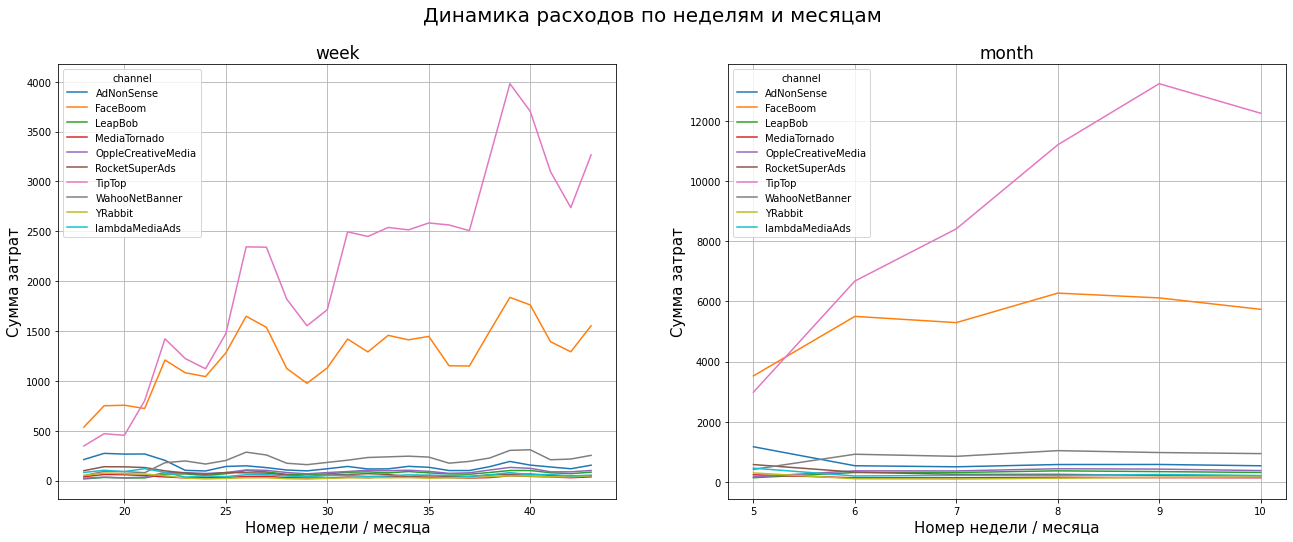

In [37]:
fig, axs = plt.subplots(figsize = (22, 8))
for i, col in enumerate(['week', 'month']):
    costs.pivot_table(index='channel',
                      columns=col,
                      values='costs',
                      aggfunc='sum').T.plot(grid=True,
                                            ax=plt.subplot(1, 2, i+1),
                                            )
    plt.title(col, fontsize=17)
    plt.xlabel('Номер недели / месяца', fontsize=15)
    plt.ylabel('Сумма затрат', fontsize=15)
fig.suptitle('Динамика расходов по неделям и месяцам', fontsize=20);

Исходя из графиков можно сделать следующие выводы:
- На протяжении всего рассматриваемого периода лидируют расходы на рекламу в источниках `FaceBoom` и `TipTop`;
- в начале рассматриваемого периода (несколько недель) расходы на рекламу в `FaceBoom` были больше, чем в `TipTop`, однако после расходы на рекламу в `TipTop` стали значительно больше и превалировали на протяжении всего оставшегося времени;
- наблюдаются пиковые расходы на рекламу во второй половине июня и во второй половине сентября;
- траты на рекламу в остальных каналах находятся примерно на одном уровне и остаются стабильными на протяжении всего анализируемого периода.

**Расчет стоимости привлечения одного пользователя (CAC) из каждого источника**

In [38]:
# исключаем органических пользователей
# группируем по источнику привлечения и считаем среднее для каждого
cac_mean = (
            profiles.query('channel != "organic"')
            .groupby('channel')
            .agg({'acquisition_cost':'mean'})
            .sort_values(by='acquisition_cost', ascending=False)
           )
cac_mean

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


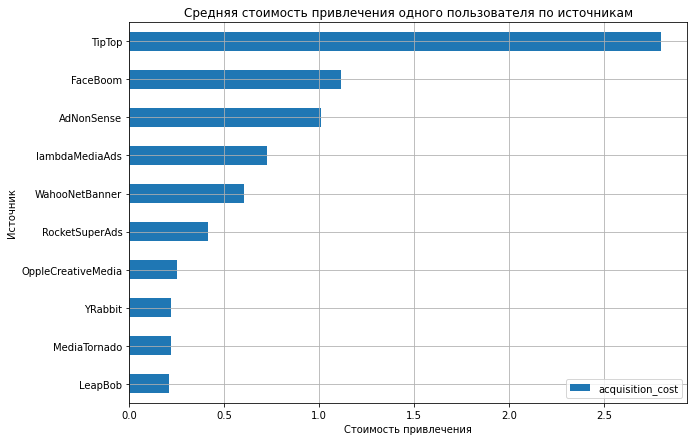

In [39]:
(cac_mean.sort_values(by='acquisition_cost', ascending=True)
         .plot(kind='barh',
               grid=True,
               figsize=(10, 7),
               title='Средняя стоимость привлечения одного пользователя по источникам')
)

plt.xlabel('Стоимость привлечения')
plt.ylabel('Источник')
plt.show()

Исходя из графика, можно сделать выводы:
- Самым дорогим каналом привлечения пользователей является `TipTop`. Средняя стоимость привлечения одного пользователя из этого источника более чем в два раза превышает вторую по величине среднюю стоимость привлечения одного пользователя (источник `FaceBoom`)
- самыми дешевыми каналами привлечения пользователей являются `LeapBob`, `MediaTomado`, `YRabbit`.

**Общий вывод**

- Общий рекламный бюджет составляет 105 497 д.е.;
- более 80% рекламного бюджета приходятся на источники `TipTop`(51.9%) и `FaceBoom`(30.8%);
- компания сделала приорететной рекламу через канал `TipTop`;
- пики рекламных расходов за рассматриваемый период приходятся на июнь и сентябрь;
- расходы на рекламу в канале `TipTop` более неравномерны нежелеи в `FaceBoom`: наблюдаются сильные скачки во время пиковых периодов;
- остальные каналы привлечения получили небольшой бюджет, расходы на рекламу в этих каналов равномерны и низки на протяжении всего периода;
- самыми дорогими каналами привлечения в расчете стоимости привлечения одного пользователя являются `TipTop` (2.8), `FaceBoom` (1.1), `AdNonSense`(1.0)

<a id ='5'></a>
### Оценка окупаемости рекламы

Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы. Будем считать, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимости включения в анализ органических пользователей нет.

- Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. Построим и изучим графики конверсии и удержания.
- Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализирем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответим на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

**Анализ окупаемости рекламы**

In [40]:
# задаем момент анализа
observation_date = datetime(2019, 11, 1).date()
# задаем горизонт анализа
horizon_days = 14

In [41]:
# исключаем органических пользователей
profiles_wo = profiles.query('channel != "organic"')
print(f'Количество профилей пользователей: {len(profiles)}')
print(f'Количество профилей пользователей без органических пользователей: {len(profiles_wo)}')

Количество профилей пользователей: 150008
Количество профилей пользователей без органических пользователей: 93569


In [42]:
# получаем LTV и ROI
result_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles_wo, orders, observation_date, horizon_days)

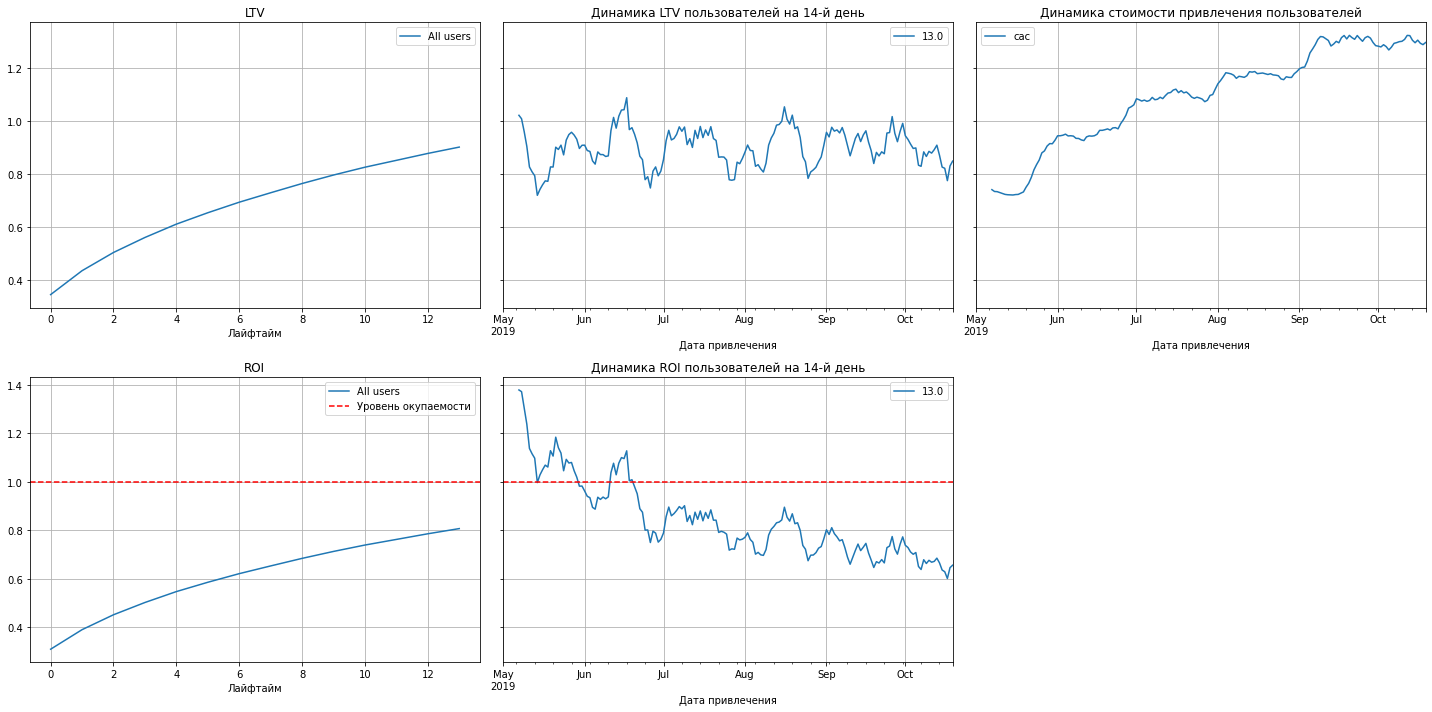

In [43]:
# визуализируем LTV и ROI
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days)

Проанализировав графики, можно сделать выводы:

 - LTV на протяжении рассматриваемого периода растет, как и ожидается, ошибок нет;
 - в динамике LTV пользователей на 14-й день набюдаются подъемы и спады, однако в целом отрицательных тенденций здесь не набюдается;
 - ROI не пересекает уровень окупаемости к концу двух недель, это говорит о том, что привлечение пользователей не окупается, условие из бизнес-плана не выполняется;
 - стоимость привлечения пользователей растет на протяжении всего рассматриваемого периода;
 - в начале рассматриваемого периода пользователи на 14-й день окупались, однако окупаемость падала, а к августу пользователи совсем перестали окупаться. Это может быть связано с постоянным ростом стоимости привлечения пользователей.

**Анализ конверсии и удержания пользователей**

In [44]:
# вычиисляем конверсию
conversion_raw, conversion, conversion_history = get_conversion(profiles_wo, orders, observation_date, horizon_days)
# получаем удержание
retention_raw, retention, retention_history = get_retention(profiles_wo, visits, observation_date, horizon_days)

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
cohort,,,,,,,,,,,,,,,
All users,88644,0.058752,0.066321,0.069999,0.072571,0.0745,0.075775,0.076745,0.077591,0.078291,0.078945,0.079362,0.079678,0.079904,0.080197


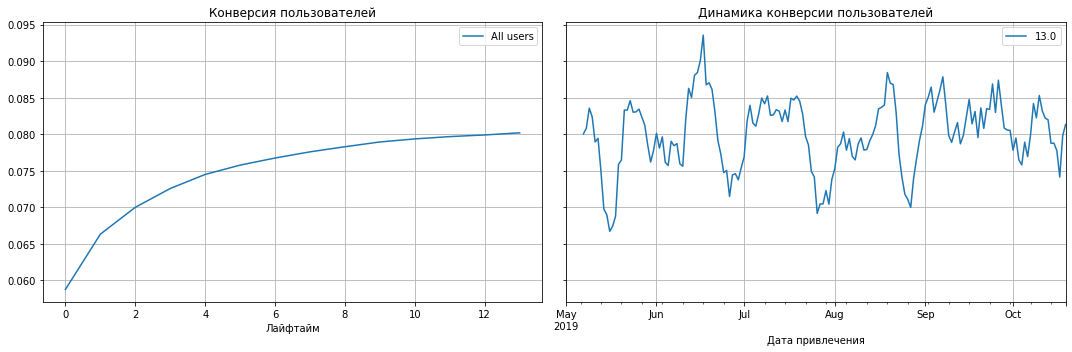

In [45]:
# выводим таблицу конверсии
display(conversion)
# визуализируем конверсию 
plot_conversion(conversion, conversion_history, horizon_days)

,cohort_size,0,1,2,3,4,5,6,7,8,9,10,11,12,13
payer,,,,,,,,,,,,,,,
False,81334,1.0,0.176876,0.086594,0.051823,0.033504,0.024701,0.018651,0.014188,0.011729,0.009541,0.007488,0.006393,0.006012,0.004709
True,7310,1.0,0.380985,0.293023,0.235568,0.210260,0.191245,0.166758,0.156908,0.145144,0.136389,0.135021,0.121888,0.118741,0.104925


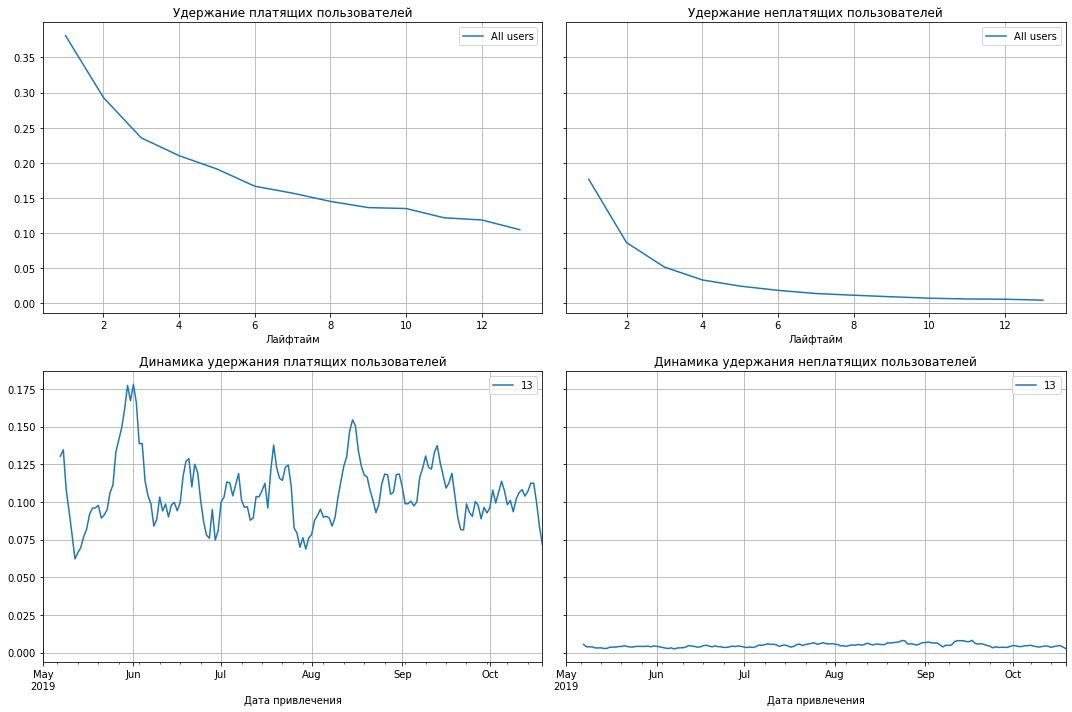

In [46]:
# выводим таблицу удержания
display(retention)
# визуализируем удержание
plot_retention(retention, retention_history, horizon_days)

Проанализировав графики, можно сделать следующие выводы:

- Конверсия пользователей к концу второй недели составляет примерно 8%;
- конверсия к концу второй недели на протяжении всего периода варьируется от 6,8% до 9,2%;
- удержание платящих пользователей к концу второй недели составляет около 10%, в то время как удержание неплатящих пользователей к концу второй недели стремится к нулю;
- динамика удержания неплатящих пользователей на протяжении всего периода стабильно очень низкая;
- присутствует явная проблема в удержании неплатящих пользователей, которая требует дальнейшего анализа и устранения, так как количество неплатящих пользователей более чем в 10 раз превышает количество платящих пользователей

**Анализ окупаемости рекламы с разбивкой по устройствам**

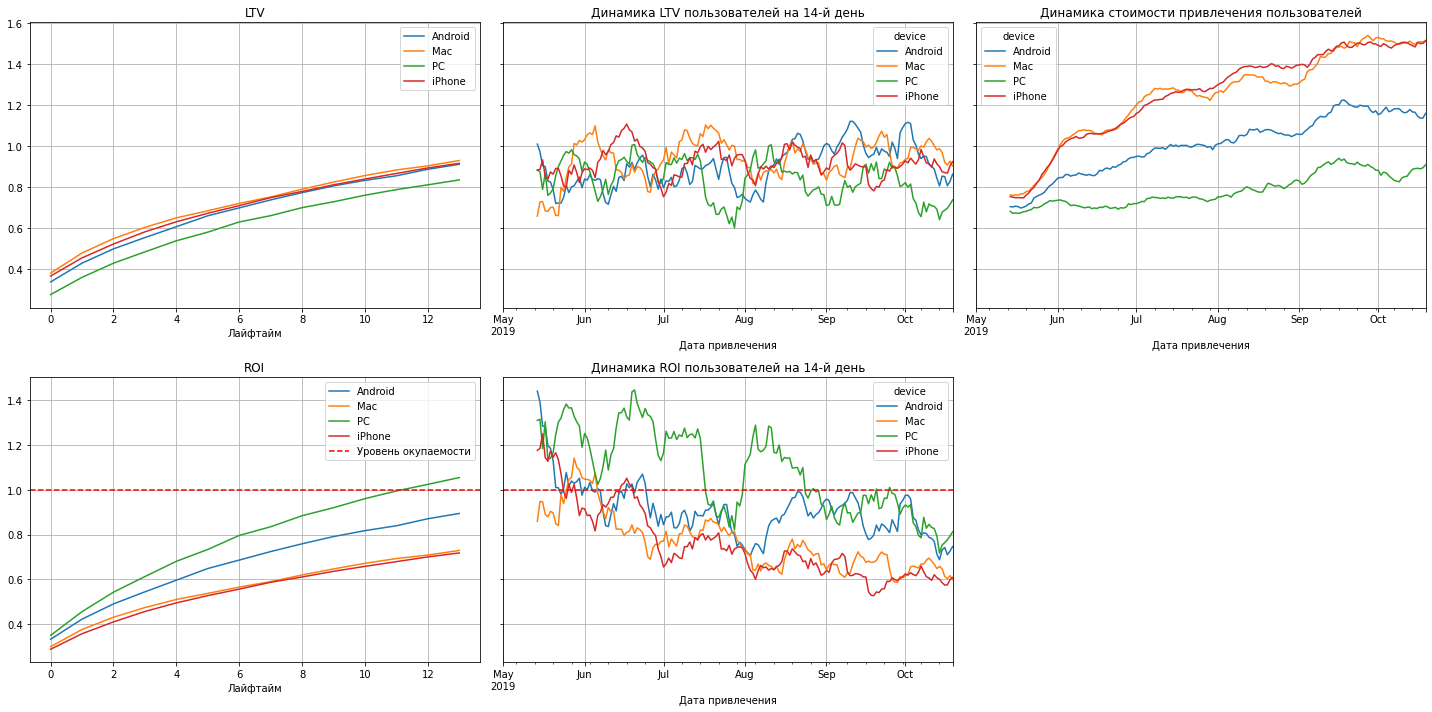

In [47]:
# получаем LTV, CAC и ROI
result_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles_wo,
                                                         orders,
                                                         observation_date,
                                                         horizon_days,
                                                         dimensions=['device'])
# визуализируем LTV, CAC и ROI
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

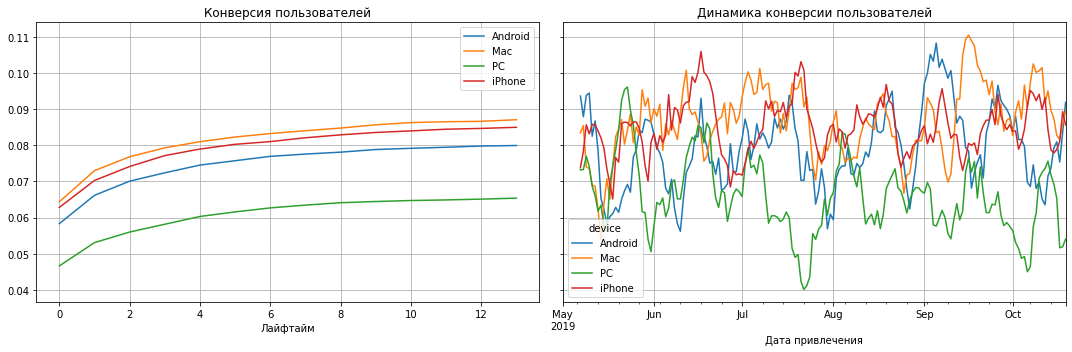

In [48]:
# вычиисляем конверсию
conversion_raw_devices, conversion_devices, conversion_history_devices = get_conversion(profiles_wo,
                                                                                        orders,
                                                                                        observation_date,
                                                                                        horizon_days,
                                                                                        dimensions=['device'])
# визуализируем конверсию 
plot_conversion(conversion_devices, conversion_history_devices, horizon_days)

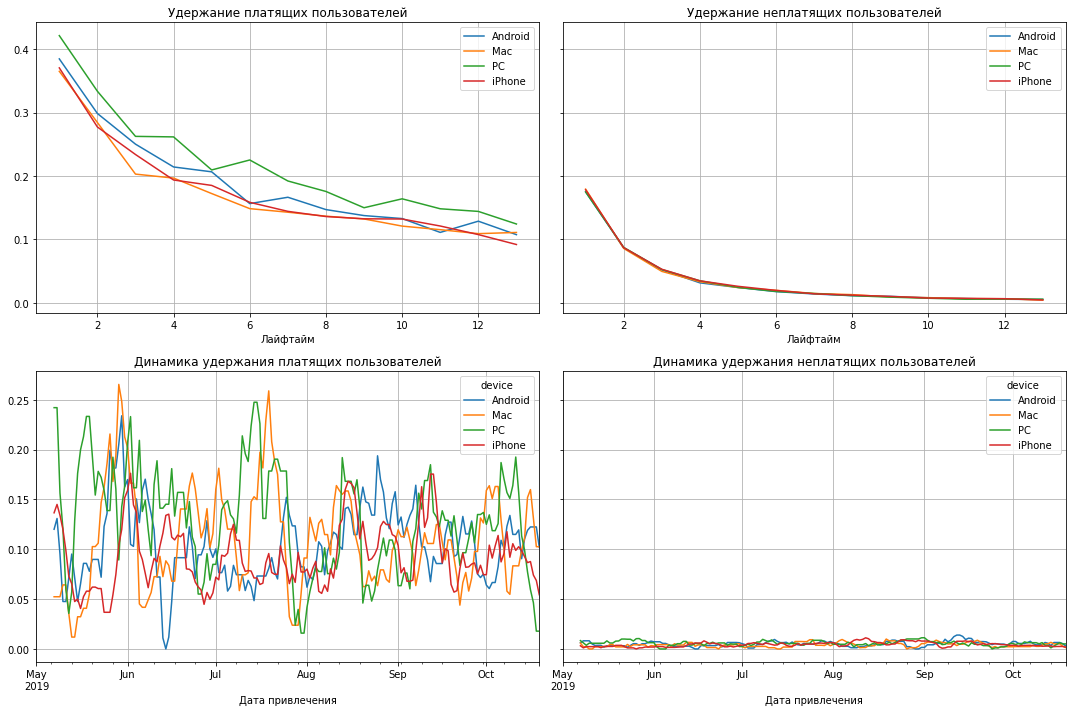

In [49]:
# получаем удержание
retention_raw_devices, retention_devices, retention_history_devices = get_retention(profiles_wo,
                                                                        visits,
                                                                        observation_date,
                                                                        horizon_days,
                                                                        dimensions=['device'])
# визуализируем удержание
plot_retention(retention_devices, retention_history_devices, horizon_days)

- LTV пользователей PC ниже LTV пользователей других устройств, однако у пользователей PC самая высокая окпуаемость, что может быть связано с тем, что реклама на PC достаточно дешевая; этот факт подтверждается графиком стоимости привлечения пользователей, на котором у PC самая низкая стоимость; однако реклама у пользователей PC не самая эффективная: уровень удержания рекламы на этих устройствах самый низкий;
- пользователи Mac, IРhone и Android имеют самый высокий LTV, однако Mac и IPhone окупаются хуже всего, что связано с высокой стоимостью рекламы на этих устройствах;
- динамика окупаемости отрицательна, причиной тому служит стабильно повышающиеся расходы на рекламу, так как LTV всех устройств на протяжении всего периода более-менее стабилен.

**Анализ окупаемости с разбивкой по регионам**

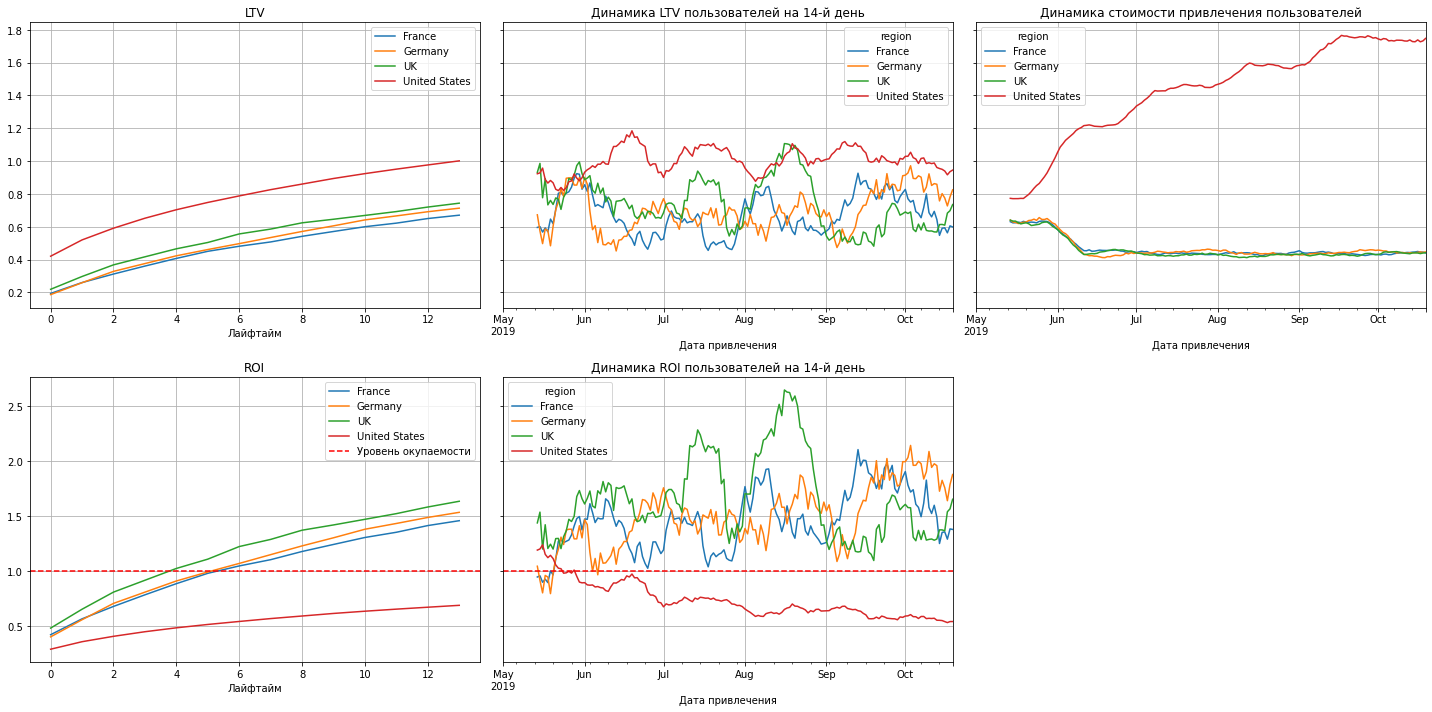

In [50]:
# получаем LTV, CAC и ROI
result_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles_wo,
                                                         orders,
                                                         observation_date,
                                                         horizon_days,
                                                         dimensions=['region'])
# визуализируем LTV, CAC и ROI
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

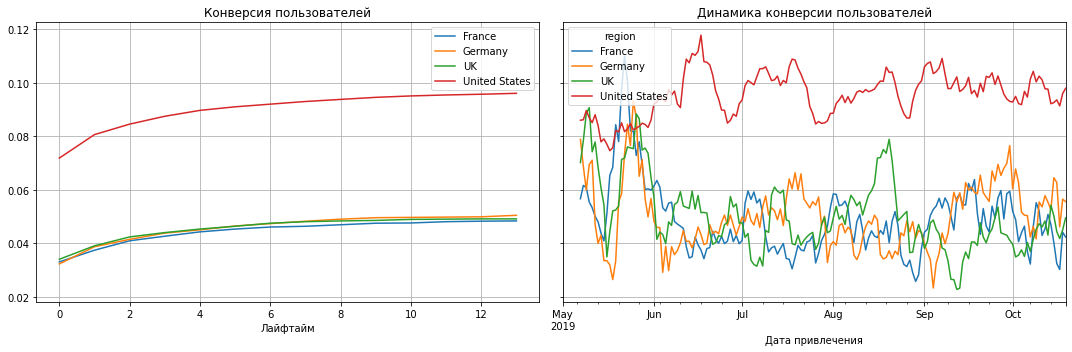

In [51]:
# вычиисляем конверсию
conversion_raw_regions, conversion_regions, conversion_history_regions = get_conversion(profiles_wo,
                                                                                        orders,
                                                                                        observation_date,
                                                                                        horizon_days,
                                                                                        dimensions=['region'])
# визуализируем конверсию 
plot_conversion(conversion_regions, conversion_history_regions, horizon_days)

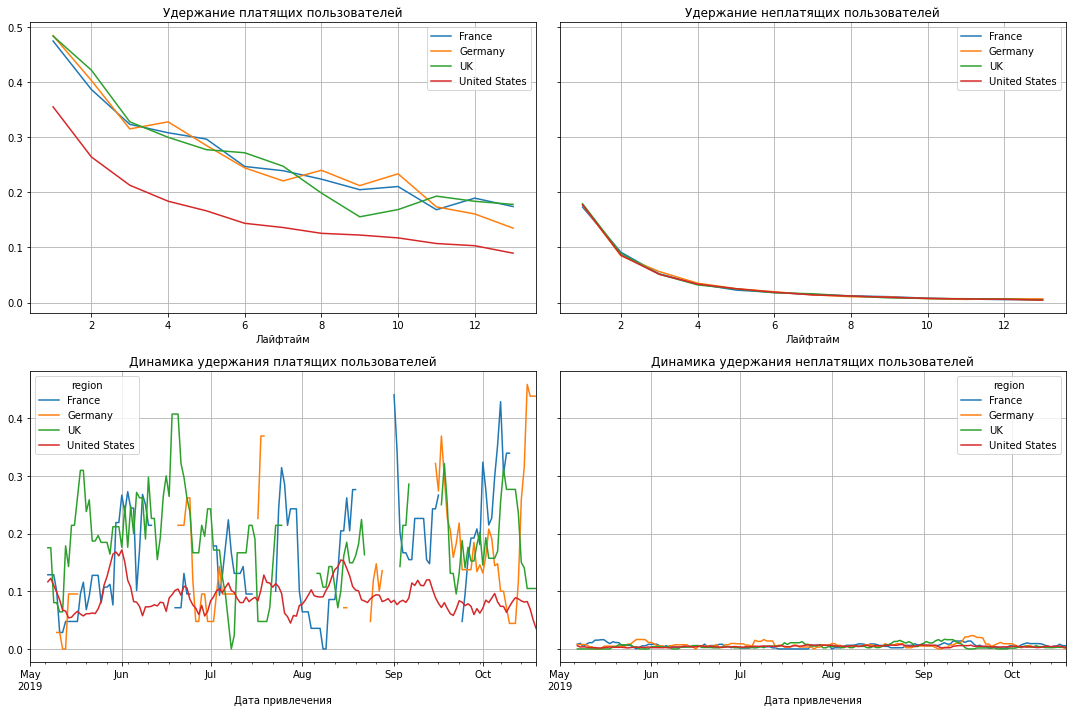

In [52]:
# получаем удержание
retention_raw_regions, retention_regions, retention_history_regions = get_retention(profiles_wo,
                                                                        visits,
                                                                        observation_date,
                                                                        horizon_days,
                                                                        dimensions=['region'])
# визуализируем удержание
plot_retention(retention_regions, retention_history_regions, horizon_days)

- LTV пользователей из США стабильно держится на высоком уровне, однако они не окупаются (ROI  в среднем 60%), динамика - отрицательна; это связано с постоянно высокими и повышающимися расходами на рекламу для пользователей из США;
- на втором месте по LTV находятся пользователи из Великобритании, они же лучше всего окупаются;
- стоимость привлечения пользователей из Германии, Великобритании и Франции находится на одном уровне и стабильна;
- пользователи из Германии, Франции и Великобритании стабильно окупаются на 4-5 день
- пользователи из США составляют 66% от общего количества пользователей, поэтому убытки от привлечения пользователей из этой страны перекрывают положительные результаты от привлечения пользователей из других стран, причина: дороговизна рекламы;
- пользователи из США отлично конвертируются в платящих, однако очень плохо удерживаются, стоит обратить на это внимание;

**Анализ окупаемости в разбивке по каналам привлечения**

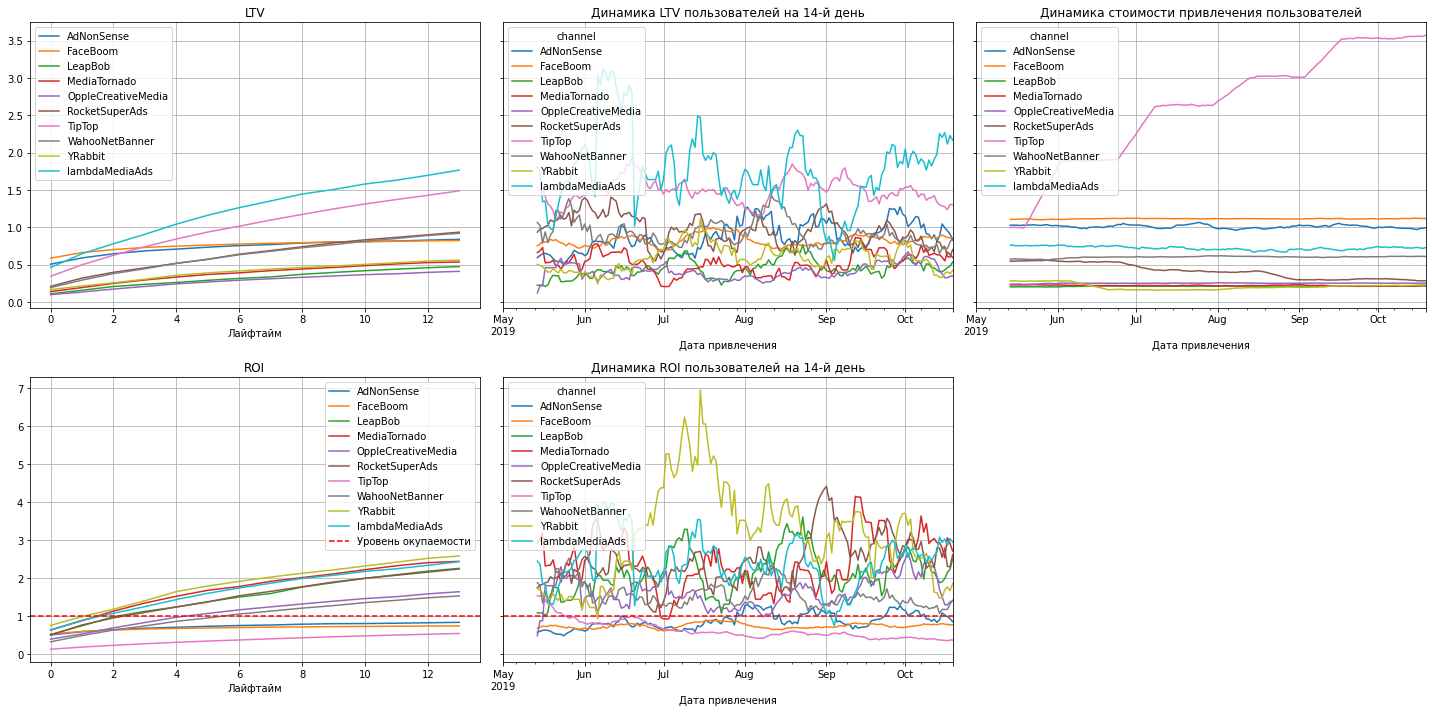

In [53]:
# получаем LTV, CAC и ROI
result_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles_wo,
                                                         orders,
                                                         observation_date,
                                                         horizon_days,
                                                         dimensions=['channel'])
# визуализируем LTV, CAC и ROI
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

Из графиков можно отметить, что самым неприбыльным каналом привлечения является TipTop, так как пользователи, привлеченные с этого канала, не окупаются к концу второй недели. При этом у TipTop наблюдается неплохой уровень LTV, однако стоимость привлечения пользователей постоянно растет. Сопоставив данные наблюдения с результатами анализа окупаемости по регионам, можно сделать предположение, что *канал TipTop является основным для привлечения пользователей из США*. Проверим это, разделив профили на американские и европейские и проанализировав их по-отдельности.

In [54]:
# разделяем пользователей
profiles_usa = profiles_wo.query('region == "United States"')
profiles_others = profiles_wo.query('region != "United States"')

print(f'Количество пользовательских профилей: {len(profiles_wo)}')
print(f'Количество пользовательских профилей из США: {len(profiles_usa)}')
print(f'Количество пользовательских профилей из других стран: {len(profiles_others)}')
# проверка на то, что ничего не потерялось при разделении
if len(profiles_others) + len(profiles_usa) == len(profiles_wo):
    print('Ошибок при разделении пользователей не обнаружено.')
else:
    print('Ошибка при разделении пользователей.')

Количество пользовательских профилей: 93569
Количество пользовательских профилей из США: 61829
Количество пользовательских профилей из других стран: 31740
Ошибок при разделении пользователей не обнаружено.


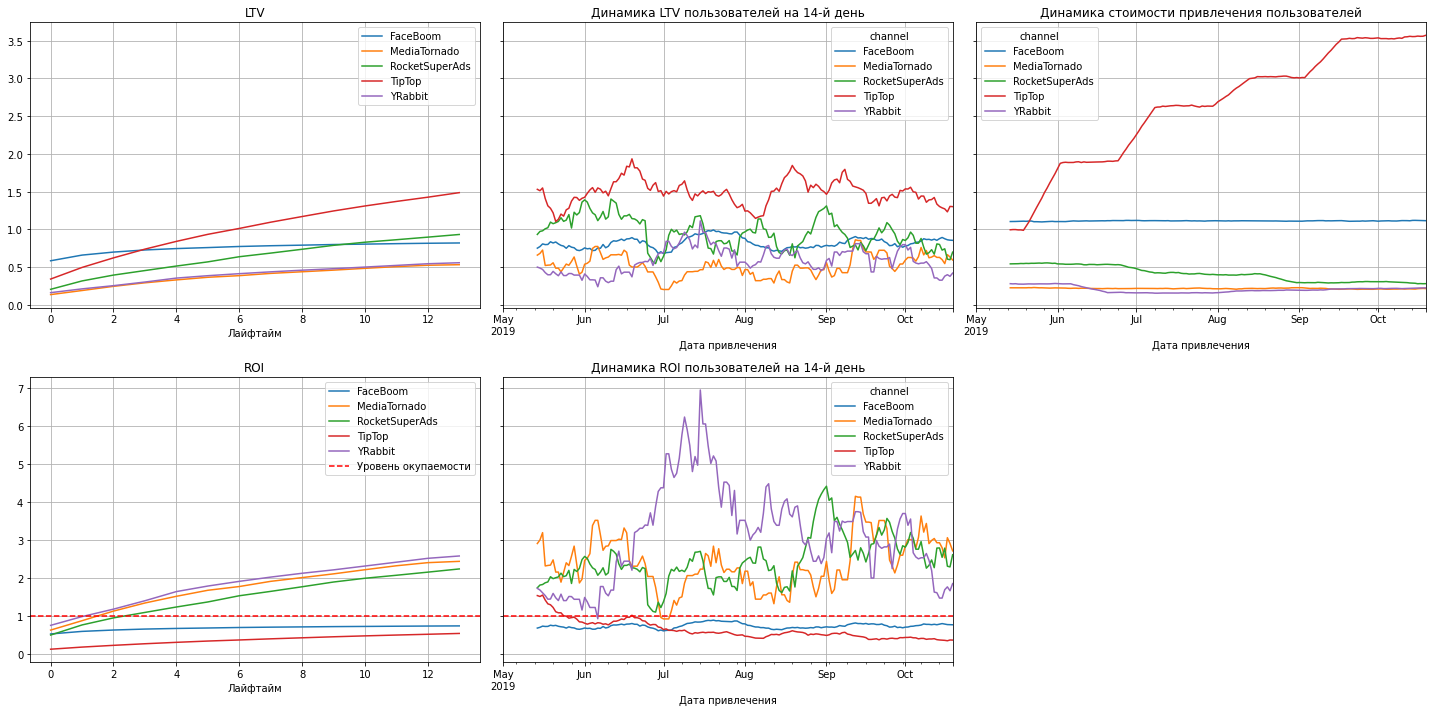

In [55]:
# пользователи из США
# получаем LTV, CAC и ROI
result_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles_usa,
                                                         orders,
                                                         observation_date,
                                                         horizon_days,
                                                         dimensions=['channel'])
# визуализируем LTV, CAC и ROI
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

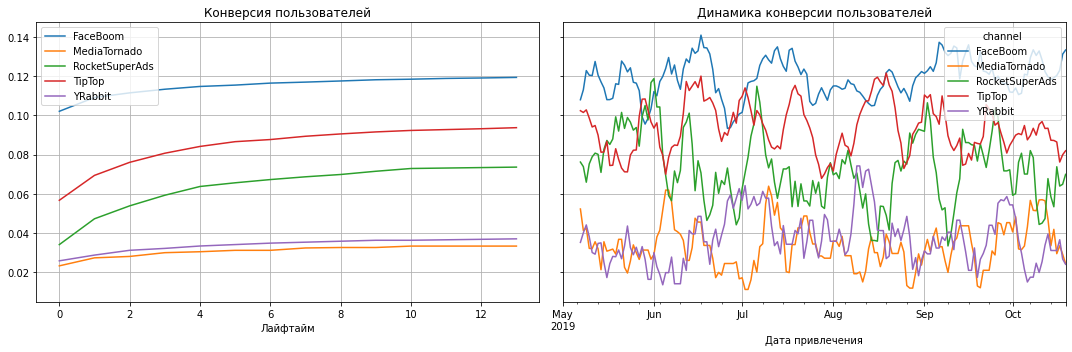

In [56]:
# вычиисляем конверсию
conversion_raw_usa, conversion_usa, conversion_history_usa = get_conversion(profiles_usa,
                                                                                        orders,
                                                                                        observation_date,
                                                                                        horizon_days,
                                                                                        dimensions=['channel'])
# визуализируем конверсию 
plot_conversion(conversion_usa, conversion_history_usa, horizon_days)

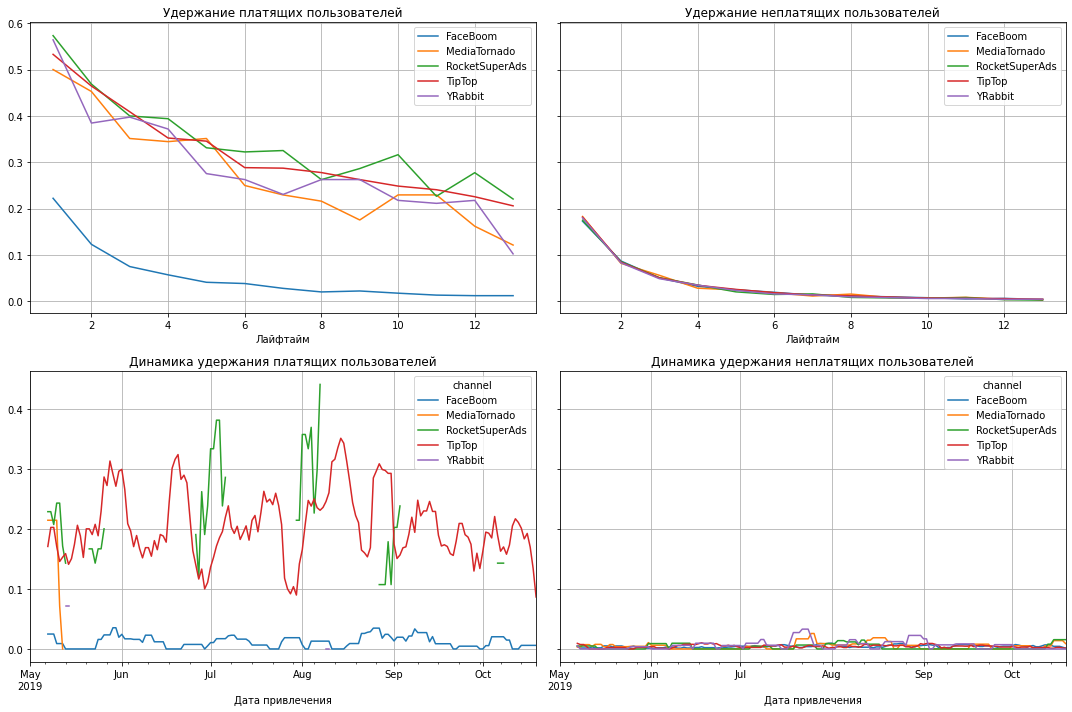

In [57]:
# получаем удержание
retention_raw_usa, retention_usa, retention_history_usa = get_retention(profiles_usa,
                                                                        visits,
                                                                        observation_date,
                                                                        horizon_days,
                                                                        dimensions=['channel'])
# визуализируем удержание
plot_retention(retention_usa, retention_history_usa, horizon_days)

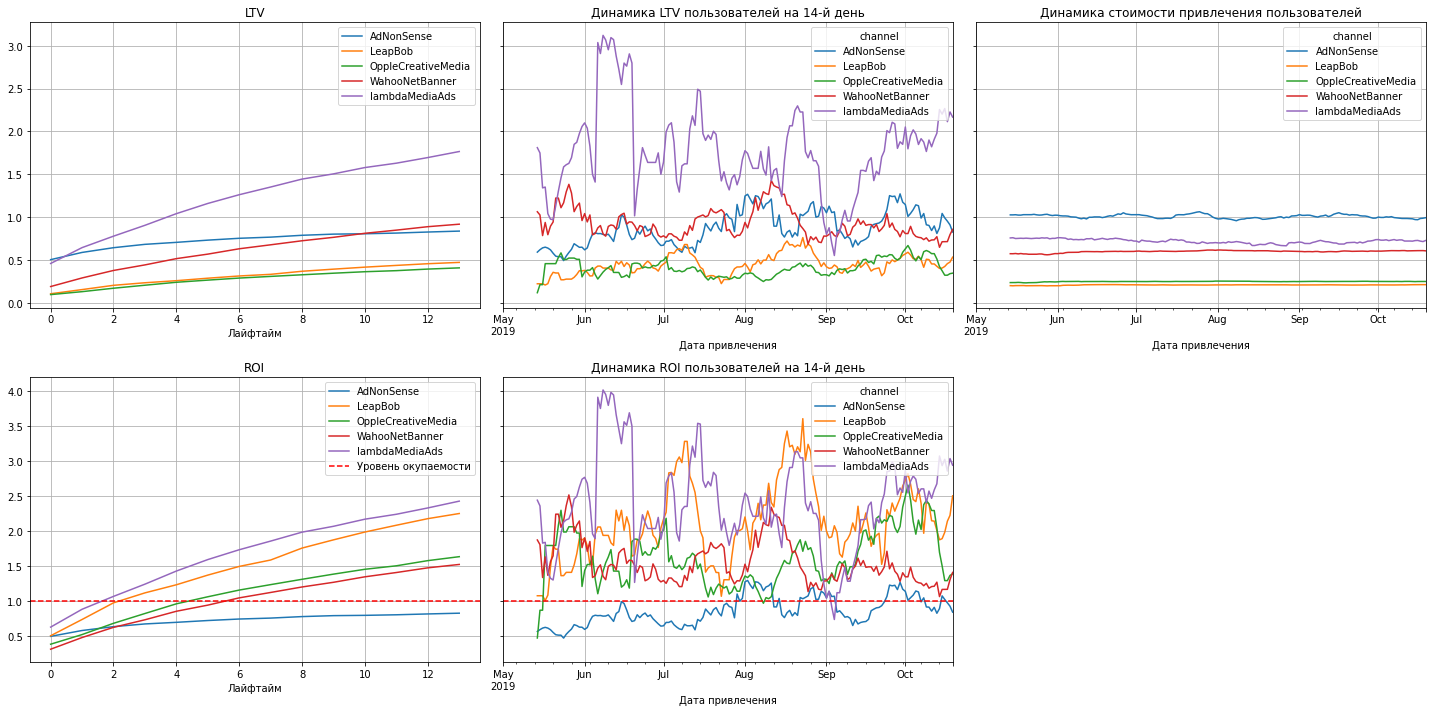

In [58]:
# пользователи из Европы
# получаем LTV, CAC и ROI
result_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles_others,
                                                         orders,
                                                         observation_date,
                                                         horizon_days,
                                                         dimensions=['channel'])
# визуализируем LTV, CAC и ROI
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

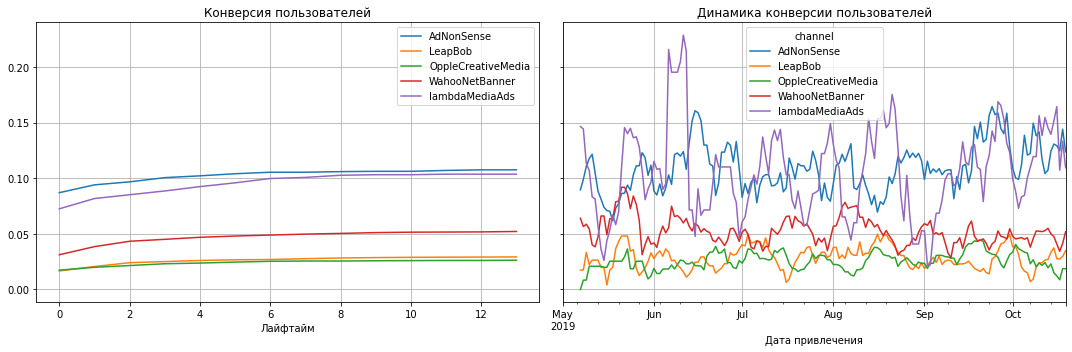

In [59]:
# вычиисляем конверсию
conversion_raw_others, conversion_others, conversion_history_others = get_conversion(profiles_others,
                                                                                        orders,
                                                                                        observation_date,
                                                                                        horizon_days,
                                                                                        dimensions=['channel'])
# визуализируем конверсию 
plot_conversion(conversion_others, conversion_history_others, horizon_days)

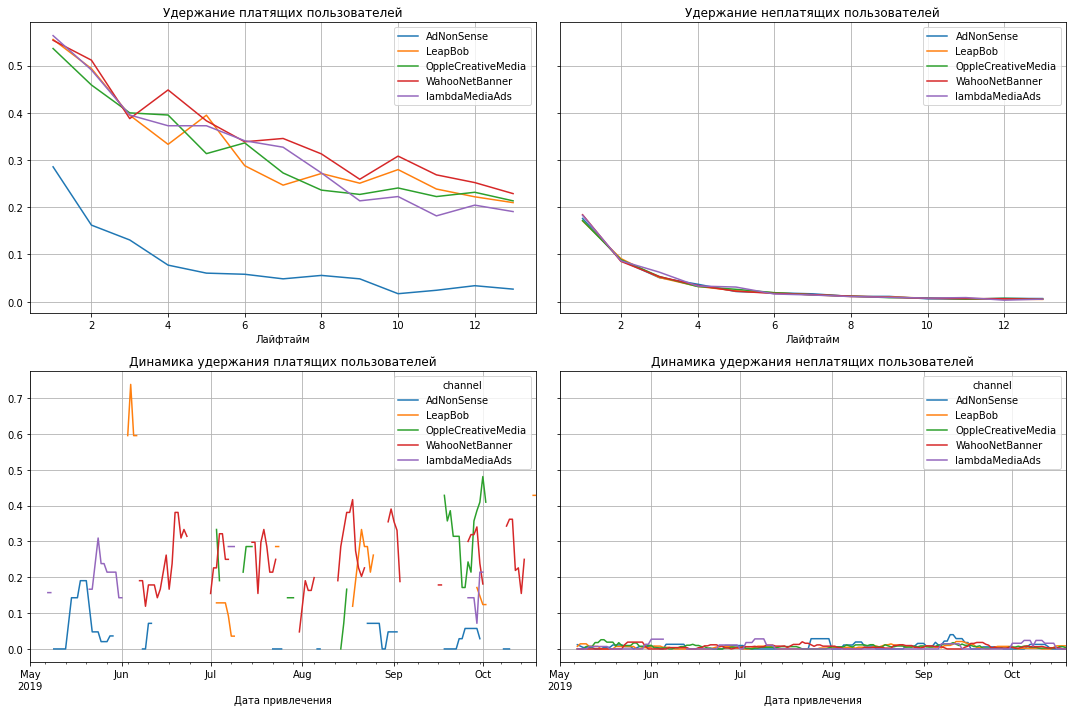

In [60]:
# получаем удержание
retention_raw_others, retention_others, retention_history_others = get_retention(profiles_others,
                                                                        visits,
                                                                        observation_date,
                                                                        horizon_days,
                                                                        dimensions=['channel'])
# визуализируем удержание
plot_retention(retention_others, retention_history_others, horizon_days)

Гипотеза подтвердилась: убыточный канал TipTop, на который выделяется 51% всего рекламного бюджета работает в основном на американскую аудиторию. Также на американскую аудиторию работает канал FaceBoom, на который выделяется 30% от всего рекламного бюджета. То есть более 80% рекламного бюджета уходит на убыточные каналы. Проанализируем и попытаемся найти причины убыточности этих каналов.

- самый высокий уровень LTV у пользователей, привлеченных из lambdaMediaAds и TipTop, однако в то время как пользователи из lambdaMediaAds окупаются на второй день, пользователи из TipTop совсем не окупаются, а уровень их окупаемости в отрицательной динамике; это связано с большими затратами на привлечение пользователей: в то время как CAC у других каналов стабилен и находится на низком уровне, CAC у TipTop очень высок и постоянно повышается; стоит отметить, что этот канал эффективен, ведь уровни удержания и конверсии у этого источника высоки, вся проблема в больших расходах на рекламу у этого канала;
- источник FaceBoom, на рекламу в котором выделяется много средств, имеет средний LTV и не окупается даже при относительно небольшой и стабильной стоимости привлечения пользователей; конверсия у этого канала высокая, однако данный канал очень плохо удерживает пользователей, а потому неэффективен (именно показатели этого канала объясняют выводы при анализе пользователей из США: высокая конверсия, но низкое удержание);
- самый высокий уровень окупаемости у американского канала YRabbit, хотя LTV у этого канала невысок: связано это с тем, что на этом источнике одна из самых дешевых реклам; уровень удержания у этого источника высок, а уровень конверсии низок, стоит проработать этот момент, модернизировать рекламу на этом канале;
- на европейском рынке хорошие результаты показывает канал привлечения lambdaMediaAds: имеет самый высокий LTV, среднюю стоимость привлечения пользователей, высокий уровень удержания и окупается уже на второй день;
- стоит проработать структуру рекламного бюджета по каналам, возможно перераспределить средства из неэффективных и убыточных каналов в потенциально прибыльные каналы.

<a id ='6'></a>
### Общий вывод

Во время выполнения работы были выполнены следующие шаги и сделаны следующие выводы:

**1. Загрузка и преодбработка данных**

- скорректированы названия столбцов (приведены к snake_case);
- столбцы с датой и временем были приведены к нужному типу данных для корректного анализа;
- проблем в данных обнаружено не было: пропуски отсутствуют, явных и неявных дубликатов не обнаружено, аномалий нет.

**2. Исследовательский анализ данных**

- составлены профили пользователей;
- определены минимальная(01.05.2019) и максимальная(27.10.2019) даты привлечения пользователей;
- пользователи приходят из таких стран, как США, Великобритания, Франция и Германия, причем 66,7% всех пользователей приходятся на США;
- доля платящих пользователей выше всего у США (6,9%), а меньше всего у Франции (3,8%);
- пользователи используют такие устройства как Mac, IPhone, PC и Android, причем 36% всех пользователей предпочитают IPhone;
- доля платящих пользователей выше всего у Mac (6,4%), а меньше всего у РС (5%);
- 37,6% пользователей приходят самостотельно (organic), 19,4% пришли из канала FaceBoom, 13% из TipTop;
- в топ-5 каналов по доле платящих пользователей входят: FaceBoom(12,2%), AdNonSense(11,3%), lambdaMediaAds(10,5%), TipTop(9,6%), RocketSuperAds(7,9%);

**3. Маркетинг**

- общая сумма расходов на маркетинг составляет 105 497 д.е.;
- более 80% всего рекламного бюджета приходится только на два канала: TipTop (51.9%) и FaceBoom (30,8%), на остальные каналы бюджет распределен более-менее равномерно от 1% до 5%. При таком сосредотачивании на одном-двух рекламных каналах велика возможность убытков, если в этих каналах вдруг реклама оказывется неэффективной или просто не окупает себя, достигнув предельных значений (то есть большее количество пользователей из канала уже не привлечь, однако компания продолжает вкладываться в рекламу на этом канале в надежде привлечь больше);
- в динамике расходов во времени наблюдаются пиковые значения во второй половине июня и во второй половине сентрября;
- самая большая стоимость привлечения пользователя приходится на источник TipTop (2,8), далее идут FaceBoom (1,13), AdNonSense (1,01), lambdaMediaAds(0,72); самая низкая стоимость привлечения пользователя у следующих каналов: YRabbit (0,22), MediaTomado (0,22), LeapBob (0,21);

**4. Анализ окупаемости**

В целом реклама, направленная на привлечение пользователей, перестала окупаться с середины июня рассматриваемого периода. Так как LTV за весь этот период стабилен, а CAC постоянно увеличивается и достигает высоких значений, то следует вывод о том, что низкая окупаемость провоцируется высокой стоимостью привлечения пользователей. Конверсия пользователей характеризуется полъемами и спадами, но в целом стабильна и держится на уровне 8%. Удержание платящих пользователей также характеризуется подъемами и спадами, но в целом стабильно и держится на уровне 10%, однако удержание неплатящих пользователей находится на очень низком уровне и стремится к 0%. Для того, чтобы выяснить причины убыточности рекламы, анализ окупаемости был проведен по категориям (устройство, регион, канал привлечения).

- Самый низкий LTV наблюдается у пользователей PC, однако только эти пользователи окупаются к концу второй недели; связано это прежде всего с низкой стоимостью привлечения пользователей PC;
- выше всего стоимость привлечения пользователей у Mac и IPhone, они же хуже всего окупаются;
- LTV в динамике у всех устройств находится примерно на одном уровне, расхождения небольшие, а значит проблема с окупаемостью здесь вызвана именно дороговизной рекламы на этих устройствах. Однако, учитывая то, что у всех устройств наблюдается отрицательная динамика в окупаемости, то стоит сделать вывод о том, что на окупаемость здесь влияет какой-то другой фактор, а не тип устройства;
- самый высокий LTV наблюдается у пользователей, привлеченных из США, однако это единственный регион, реклама в котором не окупается (ROI 50-60% к концу второй недели). Так как пользователей из США абсолютное большинство (66%), то убытки от рекламы, влеченные из этого региона, перекрывает доходность от рекламы в других регионах. Убыточность рекламы, несмотря на высокий уровень LTV, связана с высокой и постоянно растущей стоимсотью привлечения пользователей из этого региона (1,7 в то время как у других регионов 0,4);
- во время анализа окупаемости в разбивке по источникам привлечения было выявлено, что оба источника привлечения, на которые выделяется 80% всего рекламного бюджета, работают в основном на американскую аудиторию;
- самым высоким LTV из американских источников обладает TipTop (1,5 к концу второй недели), однако здесь стоит отметить, что именно этот источник обладает высокой и постоянно растущей стоимость привлечения пользователей (3,5 к концу второй недели), что делает его убыточным (ROI 50% к концу второй недели); впрочем, этот источник можно считать эффективным из-за высокого уровня LTV, конверсии и удержания; убыточным этот канал делает именно большое вложение в него средств;
- также убыточным является и второй крупный американский источник, на который идет около 30% рекламного бюджета - FaceBoom. Здесь стоимость привлечения пользователей выше, чем у других источников (кроме TipTop), однако находится на приемлимом уровне и не повышается. Убыточность этого источника объясняется его неэффективностью: LTV находится на низком уровне;
- на европейском рынке ситуация лучше: самый высокий уровень LTV у lambdaMediaAds, стоимость привлечения пользователей приемлимая, стабильная, окупаются пользователи из этого источника уже на второй день. Данный источник может рассматриваться как приорететный для перераспределения рекламного бюджета, так как на момент анализа лишь 1,5% всего рекламного бюджета приходится на lambdaMediaAds;
- убыточным к концу второй недели на европейском рынке является лишь один источник - AdNonSense, это объясняется низкой эффективностью, низким LTV при приемлимой и стабильной стоимости привлечения пользователей, также у этого источника очень низок уровень удержания;
- потенциальными источниками для вложения рекламного бюджета могут стать YRabbit, MediaTornado и RocketSuperAds в США и LeapBob в Европе; данные источники имеют хорошую окупаемость за счет низкой стоимости привлечения пользователей, однако LTV в данных каналах также низок. В дальнейшем можно проанализировать и разработать предложения для повышения LTV в данных источниках, так как коэффициент удержания у этих источников не на низком уровне и потенциал есть.

**Рекомендации для отдела маркетинга**

- Стоит проработать эффективность распределения бюджета на маркетинг: 80% всего бюджета приходится на убыточные источники FaceBoom и TipTop;
- источник TipTop обладает высоким уровнем LTV, удержания и конверсии, этот источник эффективный, однако из-за огромной стоимости привлечения пользователя он становится убыточным;
- стоит пересмотреть бюджет на размещение на платформах TipTop, FaceBoom и AdNonSense и часть направить в более эффективные источники привлечения;
- стоит обратить внимание на рекламные каналы с хорошей окупаемостью, такие как YRabbit, MediaTornado и RocketSuperAds в США и  lambdaMediaAds и LeapBob в Европе;
- эффективность в источниках привлечения с хорошей оупаемостью, но низким LTV можно проработать за счет модернезирования рекламы (персонализировать предложения, модифицировать программы лояльности, улучшить предложения и т.д.)